# Scene Classification

## 3. Train_InceptionResNetV2
- Import pkg
- Load sample data, only first 1000 objects

Reference:
- https://challenger.ai/competitions
- https://github.com/jupyter/notebook/issues/2287

**Tensorboard**
1. Input at command:  **tensorboard --logdir=./log**
2. Input at browser:  **http://127.0.0.1:6006**

### Import pkg

In [2]:
import numpy as np
import pandas as pd
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [4]:
# import zipfile
import os
import zipfile
import math
import time
from IPython.display import display
import pdb
import json
from PIL import Image
import glob
import pickle

### Load sample data, only first 1000 objects

In [6]:
project_name = 'SC2017'
step_name = 'ResNetV2'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

run_name: SC2017_ResNetV2_20171030_134602


In [7]:
cwd = os.getcwd()
print(cwd)

input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')

D:\AIChallenger\SceneClassification2017


In [9]:
datasetName = 'test_a'
date = '20170922'

zip_path = os.path.join(input_path, 'ai_challenger_scene_{0}_{1}.zip'.format(datasetName, date))
extract_path = os.path.join(input_path, 'ai_challenger_scene_{0}_{1}'.format(datasetName, date))
image_path = os.path.join(extract_path, 'scene_{0}_images_{1}'.format(datasetName, date))
scene_classes_path = os.path.join(extract_path, 'scene_classes.csv')
scene_annotations_path = os.path.join(extract_path, 'scene_{0}_annotations_{1}.json'.format(datasetName, date))

print(zip_path)
print(extract_path)
print(image_path)
print(scene_classes_path)
print(scene_annotations_path)

D:\AIChallenger\SceneClassification2017\input\ai_challenger_scene_test_a_20170922.zip
D:\AIChallenger\SceneClassification2017\input\ai_challenger_scene_test_a_20170922
D:\AIChallenger\SceneClassification2017\input\ai_challenger_scene_test_a_20170922\scene_test_a_images_20170922
D:\AIChallenger\SceneClassification2017\input\ai_challenger_scene_test_a_20170922\scene_classes.csv
D:\AIChallenger\SceneClassification2017\input\ai_challenger_scene_test_a_20170922\scene_test_a_annotations_20170922.json


In [10]:
scene_classes = pd.read_csv(scene_classes_path, header=None)
display(scene_classes.head())

,0,1,2
0,0,航站楼,airport_terminal
1,1,停机坪,landing_field
2,2,机舱,airplane_cabin
3,3,游乐场,amusement_park
4,4,冰场,skating_rink


In [11]:
def get_scene_name(lable_number, scene_classes_path):
    scene_classes = pd.read_csv(scene_classes_path, header=None)
    return scene_classes.loc[lable_number, 2]
print(get_scene_name(0, scene_classes_path))

airport_terminal


### Load model

In [19]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from scripts.inception_resnet_v2 import InceptionResNetV2

In [20]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(80, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed_5b
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 conv2d_13
51 conv2d_15
52 conv2d_18
53 batch_normalization_13
54 batch_normalization_15
55 batch_normalization

In [21]:
def saveModel(model, modelPath, fileName):
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, fileName + '.h5')
    model.save(weigthsFile)
saveModel(model, model_path, 'ModelSaveTest')

**Train top 2 inception**

In [24]:
def get_lr(x):
    lr = 1e-3 * 0.9 ** x
    if lr < 1e-4:
        lr = 1e-4
    print(lr)
    return lr
# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(lambda x: 1e-4)
log_dir = os.path.join(log_path, run_name)
print(log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 20,
                                   zoom_range = 0.1,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)
data_train_path = os.path.join(input_path, 'data_train')
data_validation_path = os.path.join(input_path, 'data_validation')
train_generator = train_datagen.flow_from_directory(data_train_path,
                                                    target_size=(299, 299),
                                                    batch_size=2,
                                                    class_mode = "categorical")
validation_generator = train_datagen.flow_from_directory(data_validation_path,
                                                    target_size=(299, 299),
                                                    batch_size=2,
                                                    class_mode = "categorical")
# print(train_generator.classes[0:1000])
# print(validation_generator.classes[0:1000])

D:\AIChallenger\SceneClassification2017\log\SC2017_ResNetV2_20171030_134602
Found 53879 images belonging to 80 classes.
Found 7120 images belonging to 80 classes.


In [ ]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch=128,
                           epochs=2, #Increase this when not on Kaggle kernel
                           verbose=1,  #1 for ETA, 0 for silent
                           validation_data=validation_generator,
                           validation_steps=800,
                           callbacks=[annealer, tensorBoard])

Epoch 1/2
127/128 [============================>.] - ETA: 0s - loss: 4.4415 - acc: 0.0118

In [15]:
saveModel(model, model_path, run_name)

In [16]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 1.8433, final accuracy: 0.5264


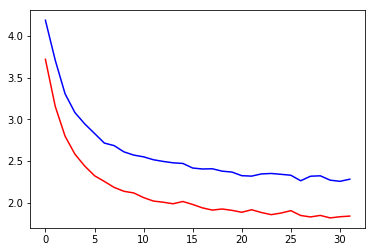

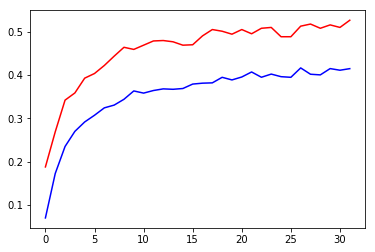

In [17]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [18]:
print('Done!')

Done!
